## Flow TSNMF Model

In [1]:
from tsnmf_edit import TSNMF
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import joblib
import matplotlib as mpl
from scipy.sparse import load_npz
import ujson as json
import seaborn as sns
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.feature_extraction.text import TfidfTransformer

# para MinMax Scaler
sup_min_bubble_size = 0
sup_max_bubble_size = 70

sns.set(style='ticks', palette='magma', context='notebook', font='Linux Biolinum O')
#%config InlineBackend.figure_format = 'retina'
%matplotlib inline

def normalize_dataframe_rows(df):
    df = pd.DataFrame(normalize(df, norm='l1'), index=df.index, columns=df.columns)
    return df

def plot_component(column, **kwargs):
    df = kwargs.pop('data')
    ax = plt.gca()
    #urban_context.plot(ax=ax, facecolor='#efefef', edgecolor='#cfcfcf')
    #highways.plot(ax=ax, color='#333333', linewidth=1)
    #primary.plot(ax=ax, color='orange', linewidth=1)
    #cycleways.plot(ax=ax, color='lime', linewidth=1)

    scaler = kwargs.pop('scaler', None)
    sizes = scaler.transform(np.sqrt(df[column].values.reshape(-1, 1)))
    ax.scatter(df.geometry.x, df.geometry.y, s=sizes, color='#4B0082', alpha=0.5, zorder=20)
    plt.axis('off')
    plt.axis('equal')

findfont: Font family ['Linux Biolinum O'] not found. Falling back to DejaVu Sans.


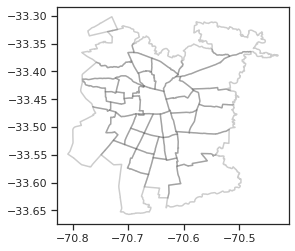

In [2]:
RM_map = gpd.read_file('maps/R13/LIMITE_URBANO_CENSAL_C17.shp')
RM_map['COMUNA'] = RM_map['COMUNA'].astype(np.int)
RM_map = RM_map.set_index('COMUNA')
# Descarto algunas zonas
RM_map2 = RM_map[RM_map.NOM_CATEG=='CIUDAD']
RM_map = RM_map2[~RM_map2.NOM_COMUNA.isin(['CURACAVÍ', 'TILTIL', 'SAN JOSÉ DE MAIPO', 'PIRQUE', 'EL MONTE','TALAGANTE','MELIPILLA', 'LAMPA', 'COLINA', 'CALERA DE TANGO', 'PEÑAFLOR',  'BUIN', 'ISLA DE MAIPO', 'PAINE'])]#rm_map[rm_map.NOM_COMUNA==rm_map.URBANO]
RM_map = RM_map[~RM_map.URBANO.isin(['CIUDAD DEL VALLE'])]
RM_map = gpd.read_file('maps/R13/LIMITE_URBANO_CENSAL_C17.shp')
RM_map['COMUNA'] = RM_map['COMUNA'].astype(np.int)
RM_map = RM_map.set_index('COMUNA')
# Descarto algunas zonas
RM_map2 = RM_map[RM_map.NOM_CATEG=='CIUDAD']
RM_map = RM_map2[~RM_map2.NOM_COMUNA.isin(['CURACAVÍ', 'TILTIL', 'PADRE HURTADO', 'SAN JOSÉ DE MAIPO', 'PIRQUE', 'EL MONTE','TALAGANTE','MELIPILLA', 'COLINA', 'CALERA DE TANGO', 'PEÑAFLOR',  'BUIN', 'ISLA DE MAIPO', 'PAINE'])]#rm_map[rm_map.NOM_COMUNA==rm_map.URBANO]
RM_map = RM_map[~RM_map.URBANO.isin(['CIUDAD DEL VALLE', 'BATUCO', 'CHICAUMA', 'LAMPA'])]
RM_map.boundary.plot(color='black', alpha=0.2)

### Importamos datos de las Zonas
Al hacer prediciones del *mnlogit model*, el `input` necesita tener las features correspondientes a la formula utilizada en `EOD_Model_v2.ipynb`.

Por ahora `zone_income` es el único modificable

In [3]:
# Importamos el id, area, la comuna a que pertenece y la geometria
zones = gpd.read_file('json/urban_zones_2016.json').set_index('ID').to_crs({'init': 'epsg:5361'})
# Distancias entre un origen y un destino
zone_distances = pd.read_csv('2017_results/zone_distances.csv.gz', index_col=['ZonaOrigen', 'ZonaDestino'])
# Periodo en el que se realizo el viaje
zone_matrix = pd.read_json('2017_results/od_matrix_per_zone.json.gz', lines=True)
period_matrices = zone_matrix.groupby(['period', 'origin_zone', 'destination_zone'])['trip_count'].mean()

/home/vnavarro/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [4]:
# Media de Ingresos por Hogar segun zona
zone_income = pd.read_csv('2017_results/zone_income.csv.gz', index_col='Zona')
zone_mindist  =  np.sqrt(pd.read_csv('2020_results/mindist_zonahogar.csv', index_col='Zona'))

## Importamos las Torres y Waypoints

Al usar *TSNMF* el modelo utiliza los waypoints. En el resultado final la matriz **W** almacena las torres.

In [5]:
# Torres de telefonía ya etiquetadas
towers =  gpd.read_file('2017_results/towers_with_labels.geo.json').set_index('tower')
# Puntos de referencia entre zonas
waypoints = load_npz('2017_results/waypoints_between_zones.npz')
waypoint_index = pd.read_json('2017_results/waypoints_between_zones_index.json.gz', lines=True)
periods = waypoint_index.period.unique()
idx_to_tower = dict(zip(range(len(towers)), towers.index.values))
tower_idx = dict(zip(towers.index.values, range(len(towers))))


In [6]:
def find_tower_labels(keys):
    return set(towers[keys].sum(axis=1)
            .pipe(lambda x: x[x > 0].copy())
            .index.values)

rail_keys = find_tower_labels(['within_metro', 'near_surface_metro', 'near_train'])
bus_keys = find_tower_labels(['near_bus_corridor', 'near_bus_routes'])
motorized_keys = find_tower_labels(['near_highways', 'near_primary_streets', 'near_secondary_streets'])
non_motorized_keys = find_tower_labels(['near_cycleways'])
taxi_keys = find_tower_labels(['near_share_taxi'])

labeled_keys = {
    'bus': bus_keys, # - (motorized_keys | rail_keys),
    'rail': rail_keys, # - (bus_keys | motorized_keys),
    'private': motorized_keys, # - (bus_keys | taxi_keys | rail_keys | non_motorized_keys),
    'shared_taxi': taxi_keys, # - (motorized_keys | rail_keys | non_motorized_keys) 
    'non_motorized': non_motorized_keys# - (bus_keys | rail_keys | motorized_keys | pedestrian)
}

topic_ids = dict(zip(labeled_keys.keys(), range(len(labeled_keys))))

labels = []
for idx in tower_idx:
    #print(idx)
    tower_label = []
    for topic_name, topic_id in topic_ids.items():
        if idx in labeled_keys[topic_name]:
            tower_label.append(topic_id)
    labels.append(tower_label)

#### Se plotean las torres sobre la Región Metropolitana

findfont: Font family ['Linux Biolinum O'] not found. Falling back to DejaVu Sans.


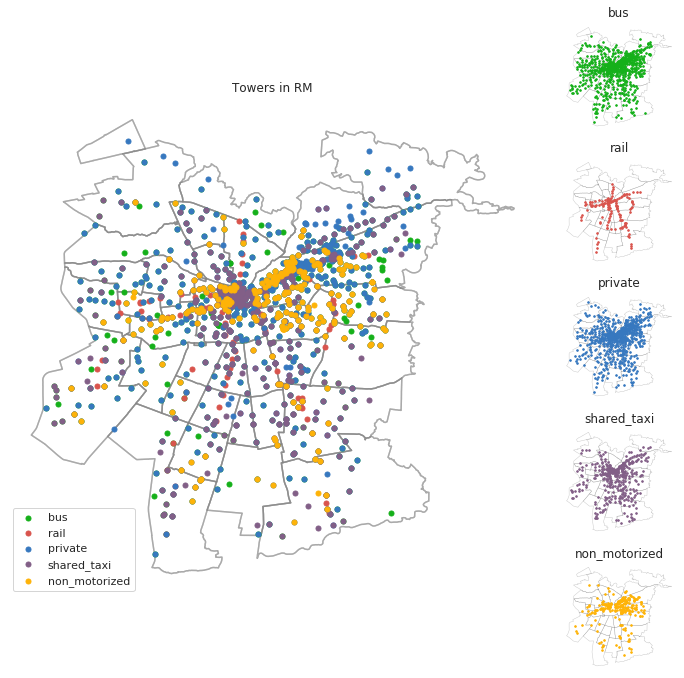

In [7]:
colors = sns.color_palette('Set2', n_colors=len(labeled_keys)+2)
colors = ['green', 'pale red', 'windows blue', 'dusty purple', 'amber']
colors =sns.xkcd_palette(colors)
color_map = dict(zip(labeled_keys.keys(), colors))
plt.figure(figsize=(12,12))
ax1 = plt.subplot2grid((5,5), (0,0), colspan=4, rowspan=5)
ax1.axis('off')
ax_dict = {'all' : ax1}
for i, k in enumerate(labeled_keys.keys()):
    ax_dict[k] = plt.subplot2grid((5,5), (i,4))
    ax_dict[k].axis('off')
    
for label, tower_ids in labeled_keys.items():
    towers.loc[tower_ids].plot(ax=ax1, alpha=1, marker='.', markersize=100, zorder=30, 
            linewidth=1, label=label, color=color_map[label])
    ax1.set_title("Towers in RM")
    ax1.legend(loc=3)
    RM_map.boundary.plot(color='gray', alpha=0.2, ax=ax1)
    
    towers.loc[tower_ids].plot(ax=ax_dict[label], alpha=1, marker='.', markersize=10, zorder=30, 
            linewidth=1, label=label, color=color_map[label])
    ax_dict[label].set_title(label)
    RM_map.boundary.plot(color='black', alpha=0.2, ax=ax_dict[label], linewidth=0.5)


## Se importa el modelo MNLogit
Dicho modelo proviene de `EOD_Model.ipynb`

In [8]:
with open('2020_results/mnlogit_column_names.json') as f:
    mnlogit_column_names = json.load(f)
    
#mnlogit_column_names[-1] = 'shared_taxi'
mnlogit = joblib.load('2020_results/mnlogit_zone_model_instance.joblib.gz')

mnlogit_column_names

['bus',
 'intermodal_private',
 'intermodal_public',
 'non_motorized',
 'pedestrian',
 'private',
 'rail',
 'shared_taxi']

In [11]:
a = TfidfTransformer(norm='l1').fit_transform(waypoints[waypoint_periods.index]).T

In [12]:
a 

<1374x167200 sparse matrix of type '<class 'numpy.float64'>'
	with 2168317 stored elements in Compressed Sparse Column format>

Ejecutamos la iteración por periodo

Actual period: afternoon_peak
Epoch 05 reached after 0.354 seconds, error: 2207.251938
Epoch 10 reached after 0.679 seconds, error: 2162.443557
Epoch 15 reached after 1.006 seconds, error: 2153.697050
Epoch 20 reached after 1.331 seconds, error: 2151.260902
Epoch 25 reached after 1.656 seconds, error: 2150.433570
Epoch 30 reached after 1.981 seconds, error: 2150.061359
Epoch 35 reached after 2.326 seconds, error: 2149.875294
Epoch 40 reached after 2.658 seconds, error: 2149.776949
Epoch 45 reached after 2.990 seconds, error: 2149.722504
Epoch 50 reached after 3.324 seconds, error: 2149.690370
Epoch 55 reached after 3.661 seconds, error: 2149.669950
Epoch 60 reached after 4.023 seconds, error: 2149.656277
Epoch 65 reached after 4.362 seconds, error: 2149.646856
Epoch 70 reached after 4.701 seconds, error: 2149.640194
Epoch 75 reached after 5.040 seconds, error: 2149.635434
Epoch 80 reached after 5.388 seconds, error: 2149.631941
Epoch 85 reached after 5.732 seconds, error: 2149.629307
E

/home/vnavarro/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


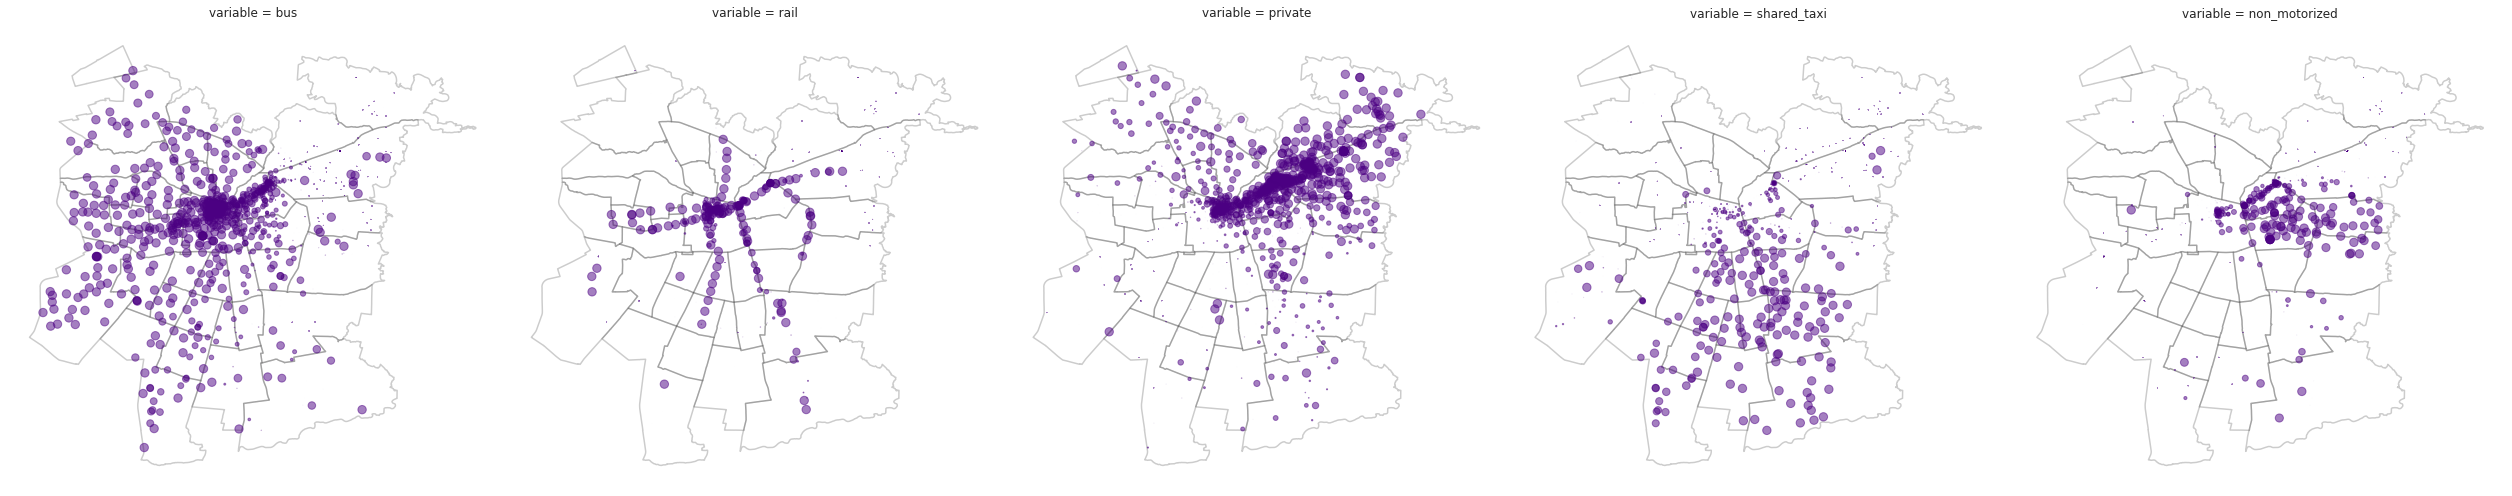

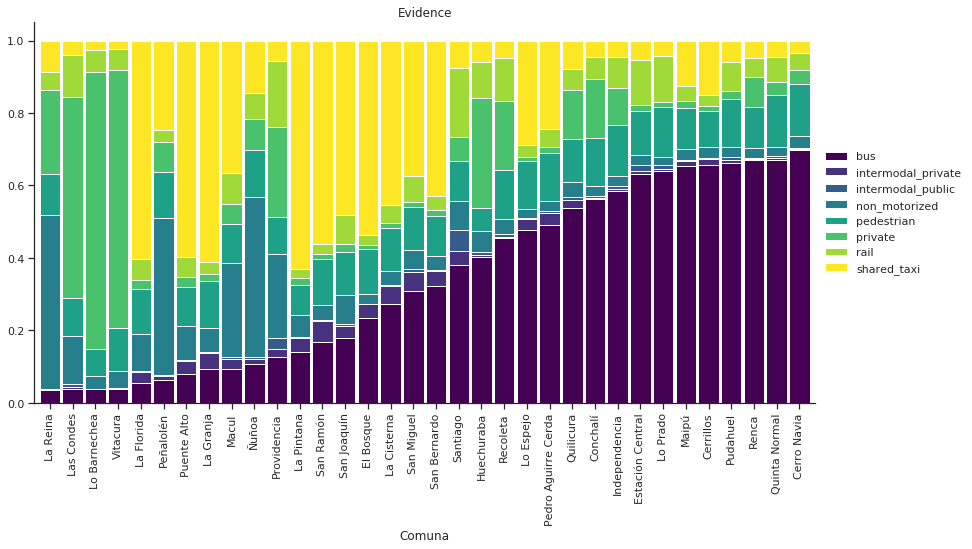

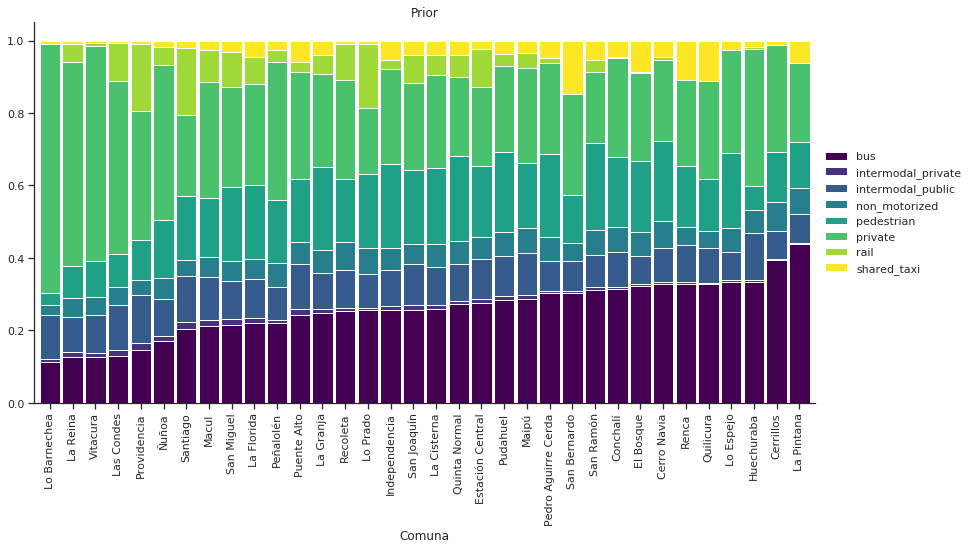

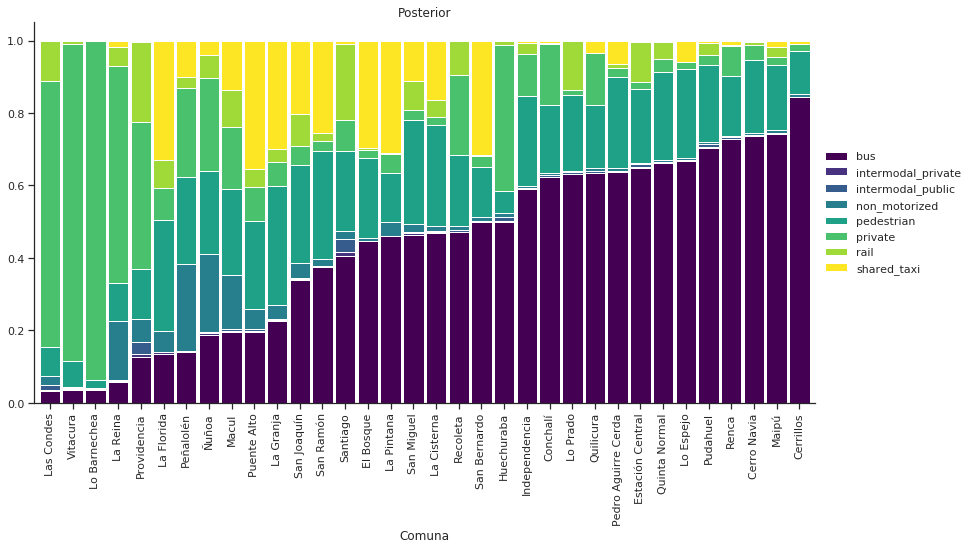

Actual period: afternoon_valley
Epoch 05 reached after 0.531 seconds, error: 2670.413325
Epoch 10 reached after 1.017 seconds, error: 2610.887624
Epoch 15 reached after 1.508 seconds, error: 2584.650335
Epoch 20 reached after 1.995 seconds, error: 2579.543788
Epoch 25 reached after 2.483 seconds, error: 2578.022433
Epoch 30 reached after 2.970 seconds, error: 2577.427015
Epoch 35 reached after 3.457 seconds, error: 2577.143192
Epoch 40 reached after 3.944 seconds, error: 2576.996424
Epoch 45 reached after 4.432 seconds, error: 2576.914744
Epoch 50 reached after 4.924 seconds, error: 2576.863620
Epoch 55 reached after 5.414 seconds, error: 2576.829215
Epoch 60 reached after 5.904 seconds, error: 2576.805159
Epoch 65 reached after 6.399 seconds, error: 2576.787790
Epoch 70 reached after 6.896 seconds, error: 2576.775158
Epoch 75 reached after 7.391 seconds, error: 2576.766015
Epoch 80 reached after 7.883 seconds, error: 2576.759332
Epoch 85 reached after 8.378 seconds, error: 2576.754335

/home/vnavarro/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


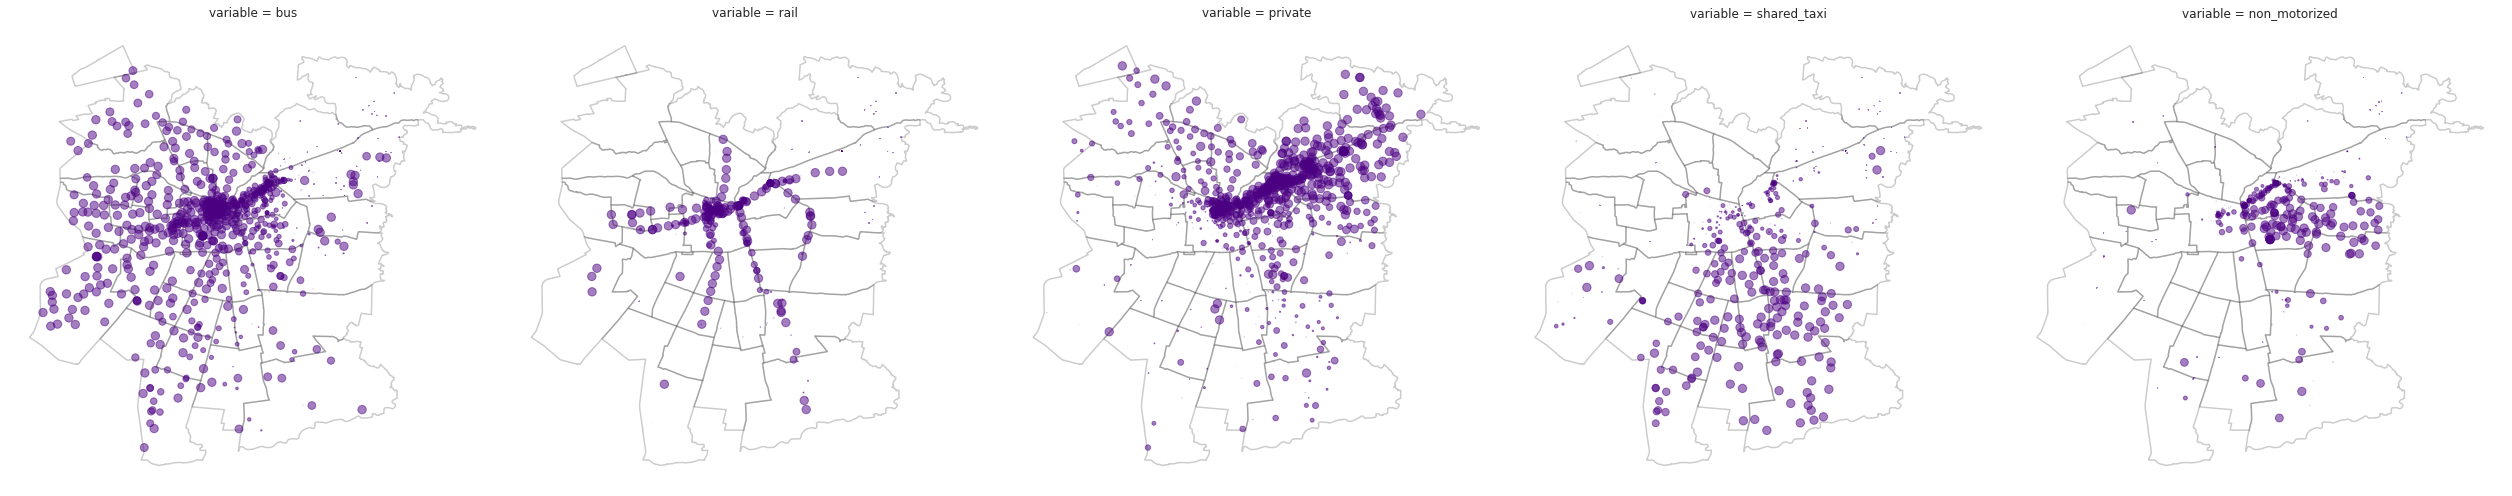

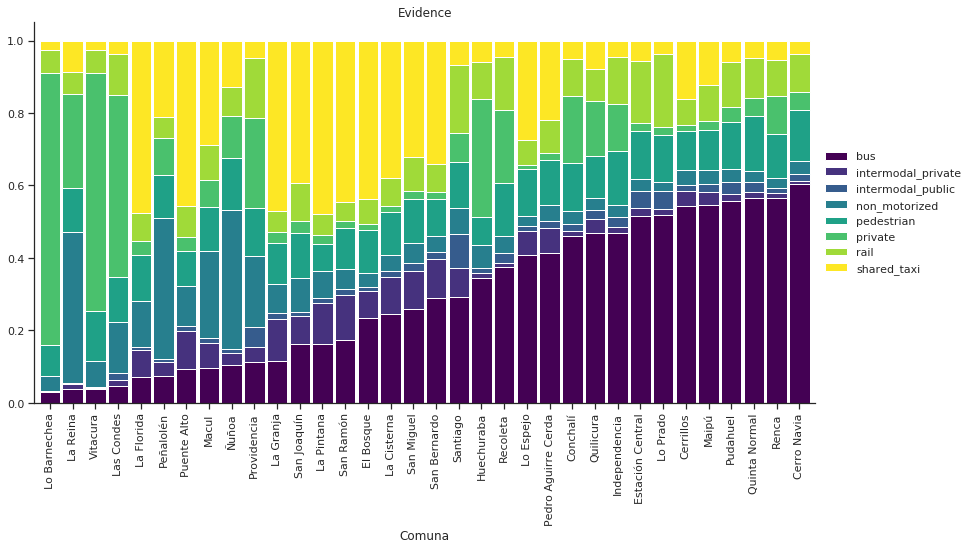

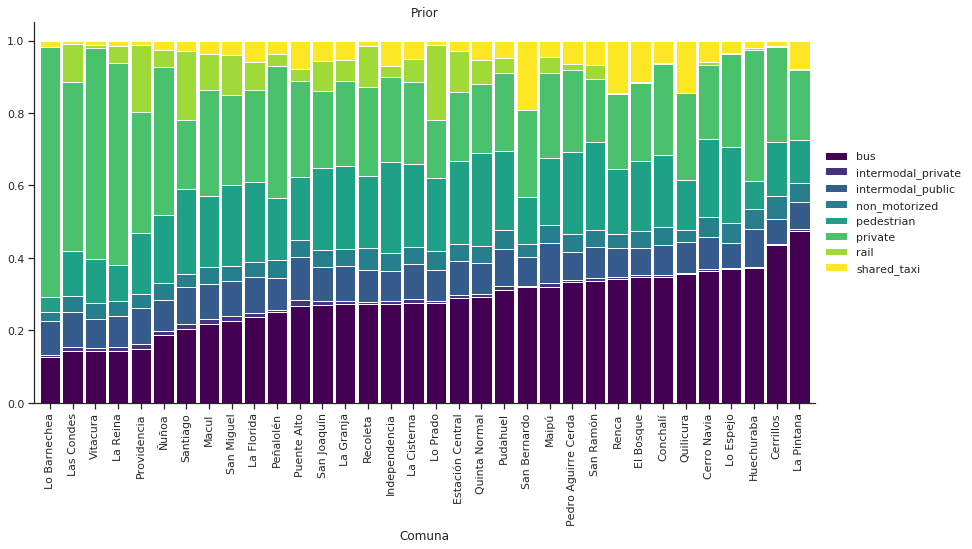

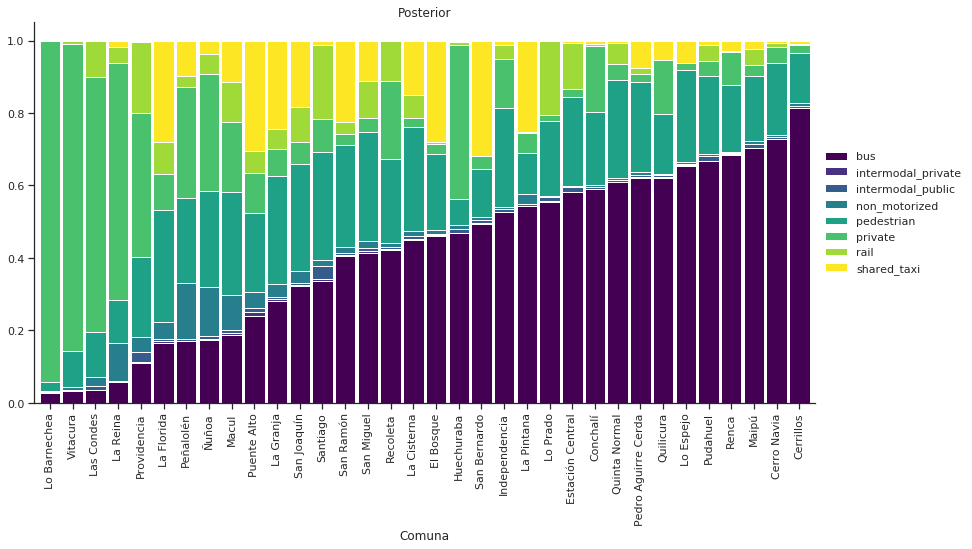

Actual period: morning_peak_1
Epoch 05 reached after 0.205 seconds, error: 1647.408493
Epoch 10 reached after 0.394 seconds, error: 1625.079733
Epoch 15 reached after 0.582 seconds, error: 1621.864036
Epoch 20 reached after 0.770 seconds, error: 1620.797904
Epoch 25 reached after 0.958 seconds, error: 1620.195717
Epoch 30 reached after 1.146 seconds, error: 1619.785231
Epoch 35 reached after 1.334 seconds, error: 1619.472170
Epoch 40 reached after 1.522 seconds, error: 1619.224282
Epoch 45 reached after 1.711 seconds, error: 1619.029727
Epoch 50 reached after 1.902 seconds, error: 1618.879861
Epoch 55 reached after 2.093 seconds, error: 1618.767329
Epoch 60 reached after 2.285 seconds, error: 1618.685232
Epoch 65 reached after 2.478 seconds, error: 1618.626215
Epoch 70 reached after 2.675 seconds, error: 1618.584850
Epoch 75 reached after 2.872 seconds, error: 1618.555238
Epoch 80 reached after 3.071 seconds, error: 1618.533373
Epoch 85 reached after 3.270 seconds, error: 1618.517484
E

/home/vnavarro/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


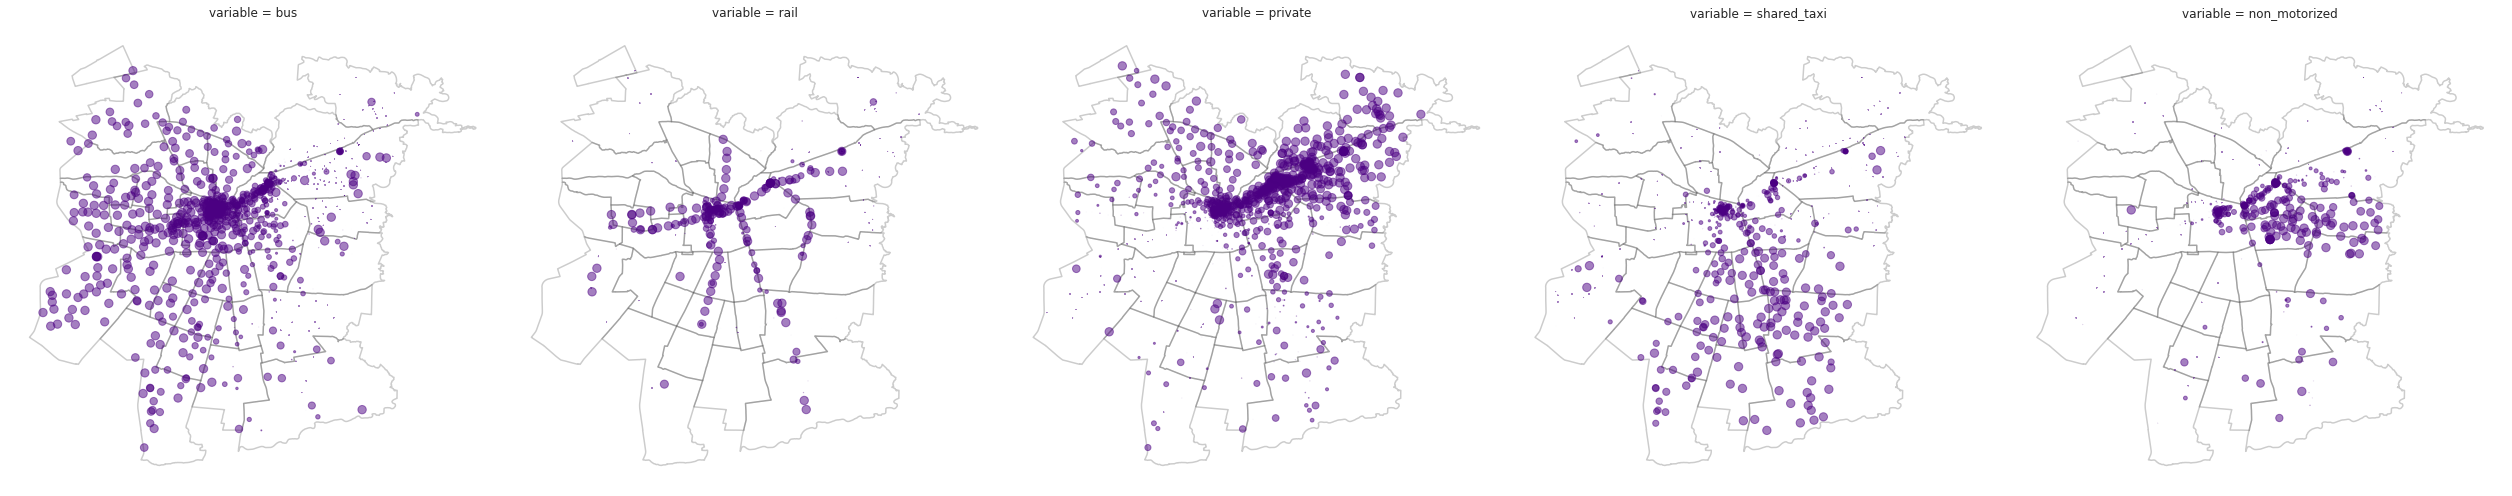

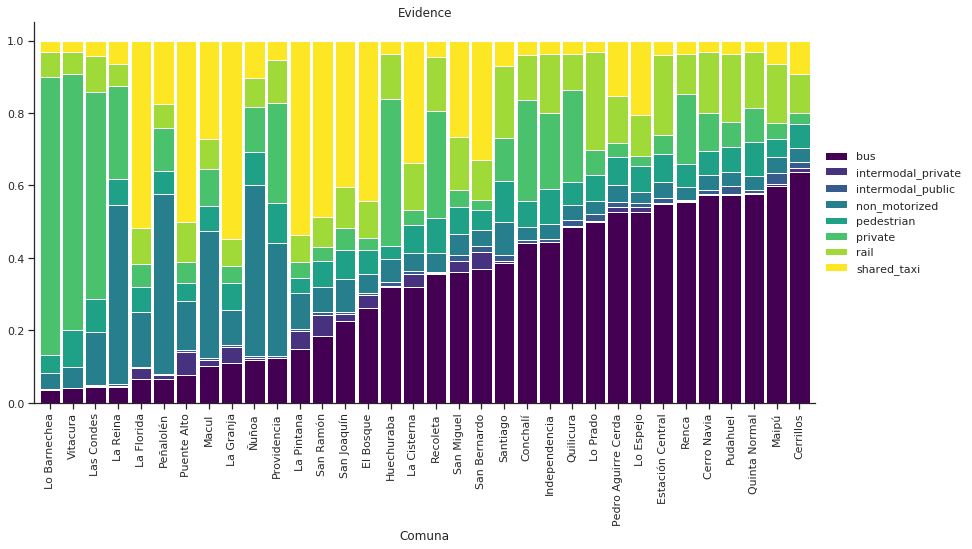

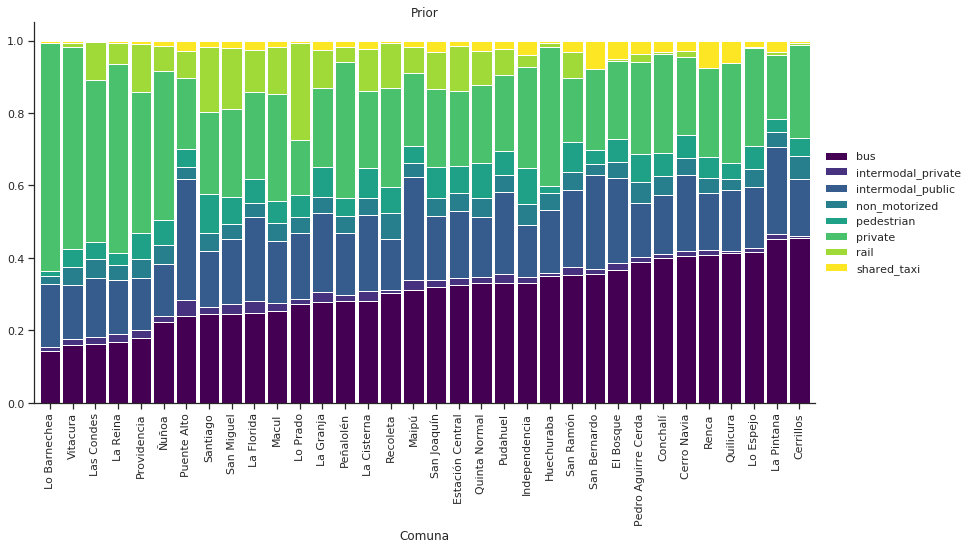

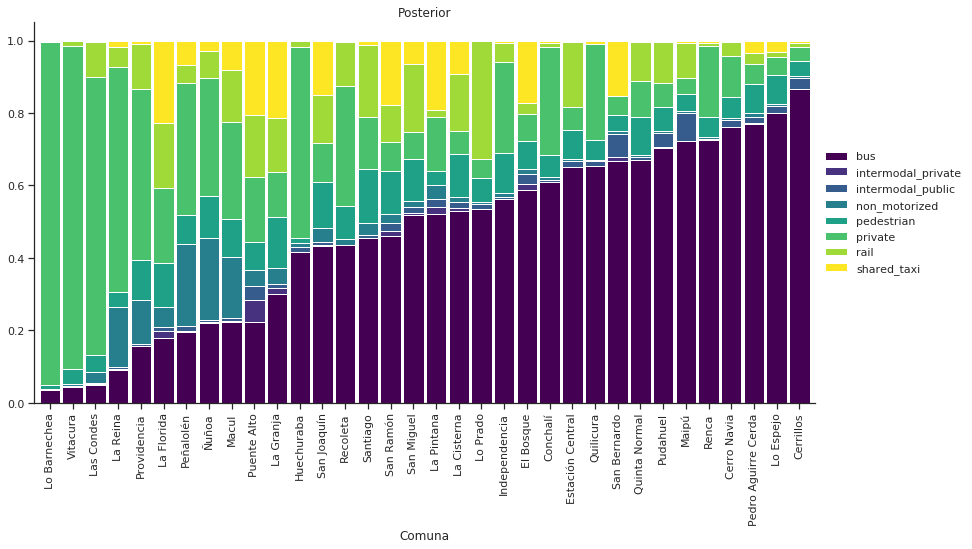

Actual period: morning_peak_2
Epoch 05 reached after 0.206 seconds, error: 1644.208101
Epoch 10 reached after 0.398 seconds, error: 1619.938984
Epoch 15 reached after 0.588 seconds, error: 1616.037741
Epoch 20 reached after 0.778 seconds, error: 1614.197350
Epoch 25 reached after 0.967 seconds, error: 1612.520088
Epoch 30 reached after 1.157 seconds, error: 1611.661672
Epoch 35 reached after 1.347 seconds, error: 1611.246661
Epoch 40 reached after 1.537 seconds, error: 1611.020991
Epoch 45 reached after 1.729 seconds, error: 1610.894537
Epoch 50 reached after 1.923 seconds, error: 1610.820597
Epoch 55 reached after 2.116 seconds, error: 1610.775074
Epoch 60 reached after 2.310 seconds, error: 1610.745506
Epoch 65 reached after 2.505 seconds, error: 1610.725288
Epoch 70 reached after 2.702 seconds, error: 1610.711326
Epoch 75 reached after 2.899 seconds, error: 1610.701433
Epoch 80 reached after 3.101 seconds, error: 1610.694085
Epoch 85 reached after 3.301 seconds, error: 1610.688560
E

/home/vnavarro/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


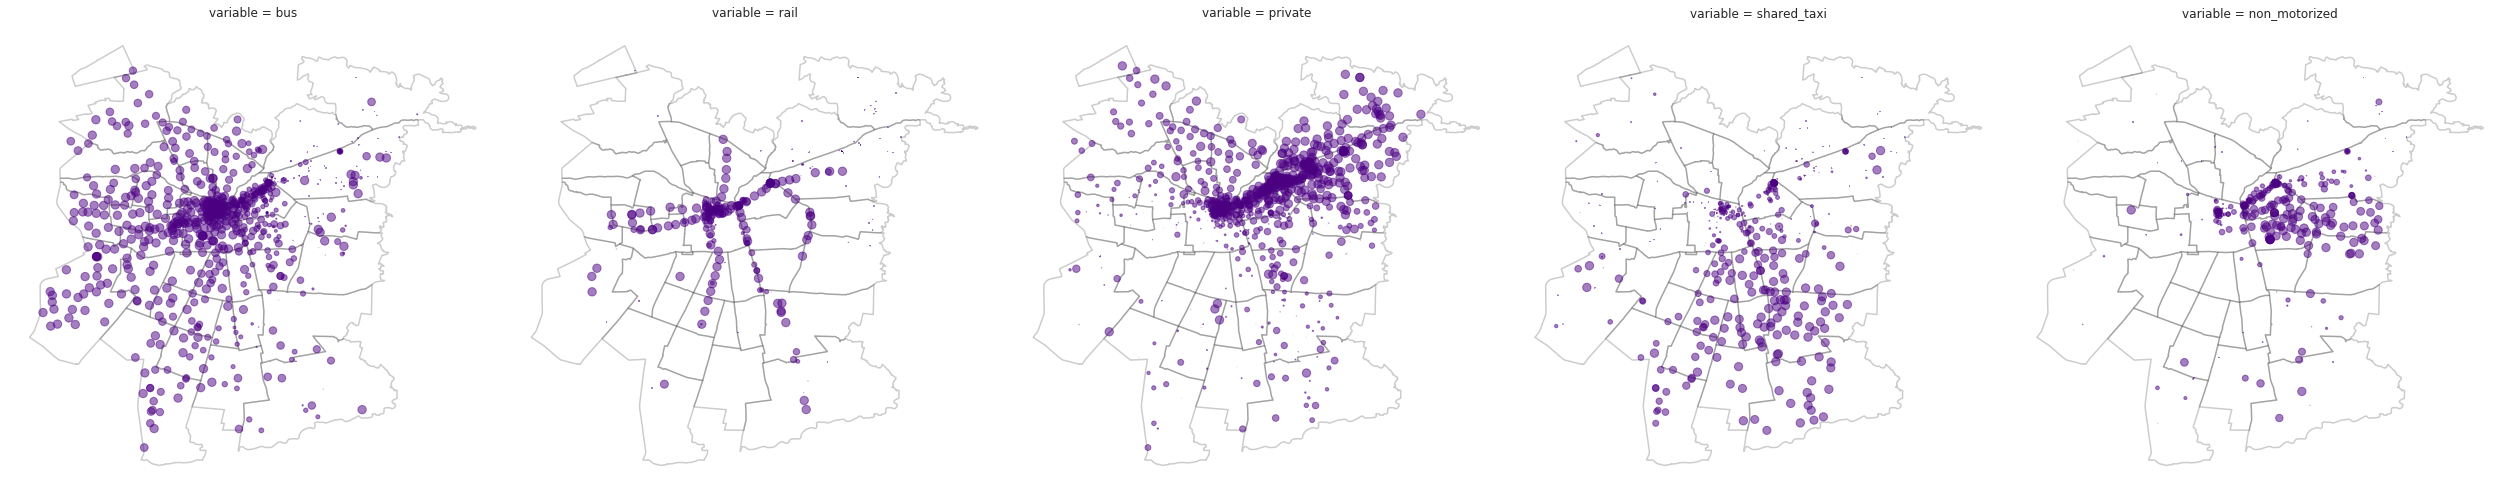

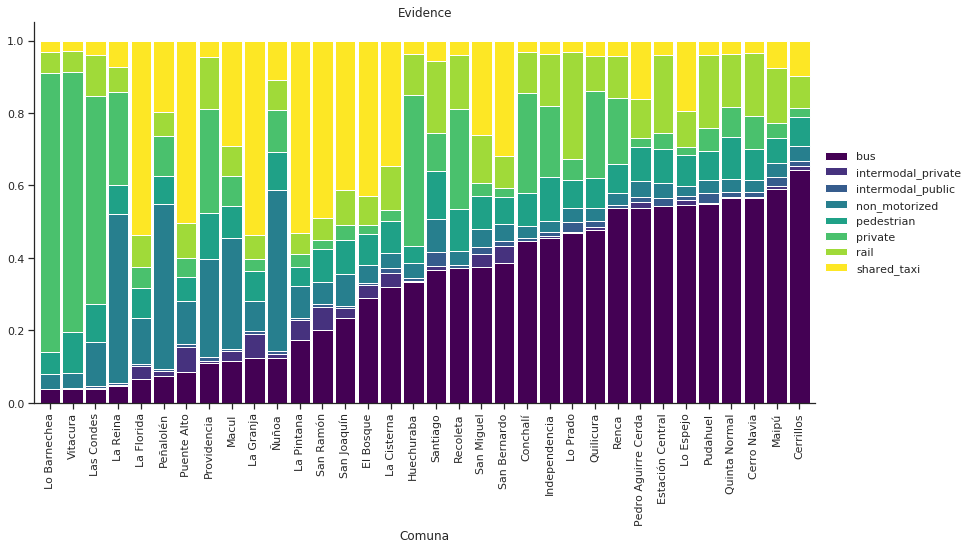

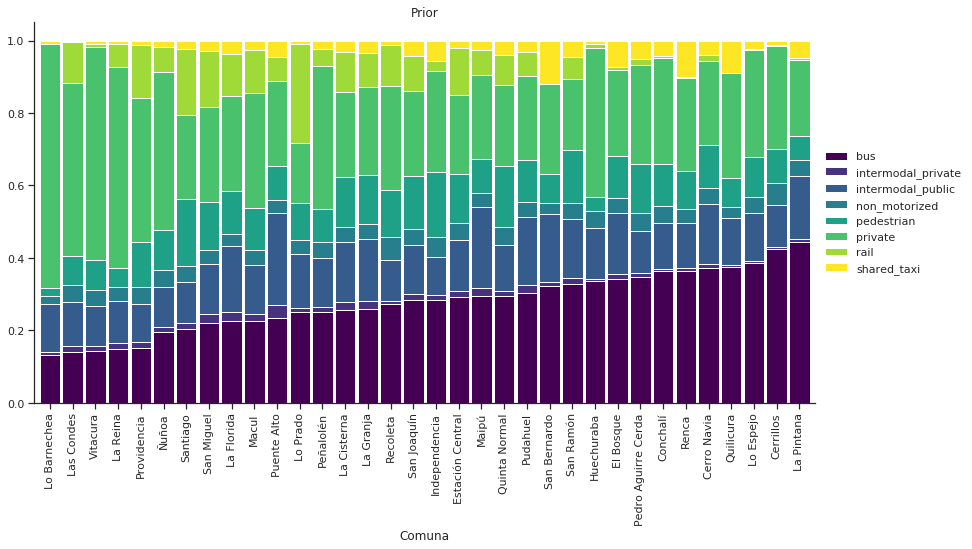

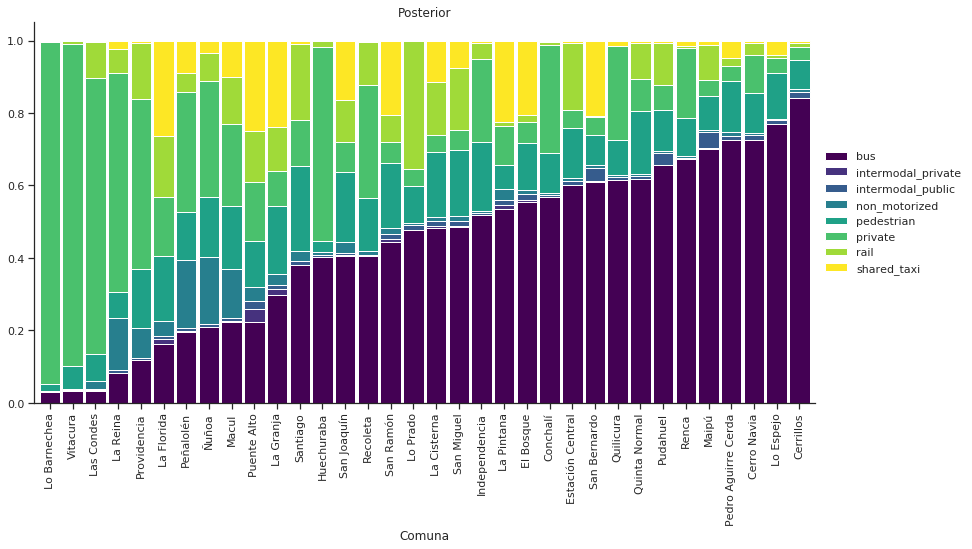

Actual period: morning_valley
Epoch 05 reached after 0.351 seconds, error: 2067.517098
Epoch 10 reached after 0.670 seconds, error: 2026.734378
Epoch 15 reached after 0.991 seconds, error: 2018.374898
Epoch 20 reached after 1.309 seconds, error: 2016.131075
Epoch 25 reached after 1.632 seconds, error: 2015.399657
Epoch 30 reached after 1.950 seconds, error: 2015.104364
Epoch 35 reached after 2.271 seconds, error: 2014.964661
Epoch 40 reached after 2.589 seconds, error: 2014.895762
Epoch 45 reached after 2.911 seconds, error: 2014.859238
Epoch 50 reached after 3.230 seconds, error: 2014.838202
Epoch 55 reached after 3.554 seconds, error: 2014.825235
Epoch 60 reached after 3.875 seconds, error: 2014.816877
Epoch 65 reached after 4.200 seconds, error: 2014.811241
Epoch 70 reached after 4.524 seconds, error: 2014.807318
Epoch 75 reached after 4.851 seconds, error: 2014.804467
Epoch 80 reached after 5.178 seconds, error: 2014.802309


/home/vnavarro/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


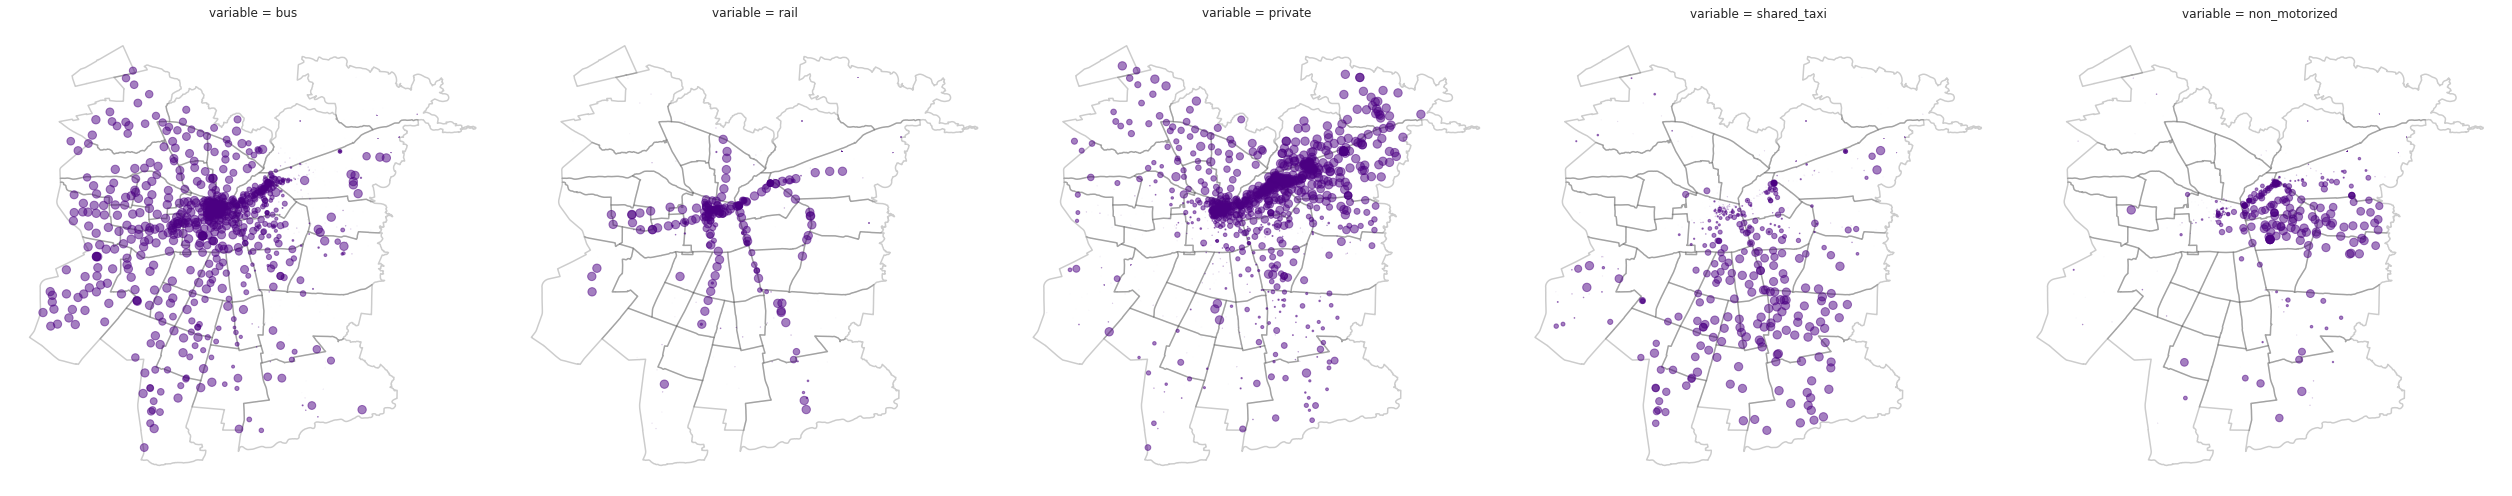

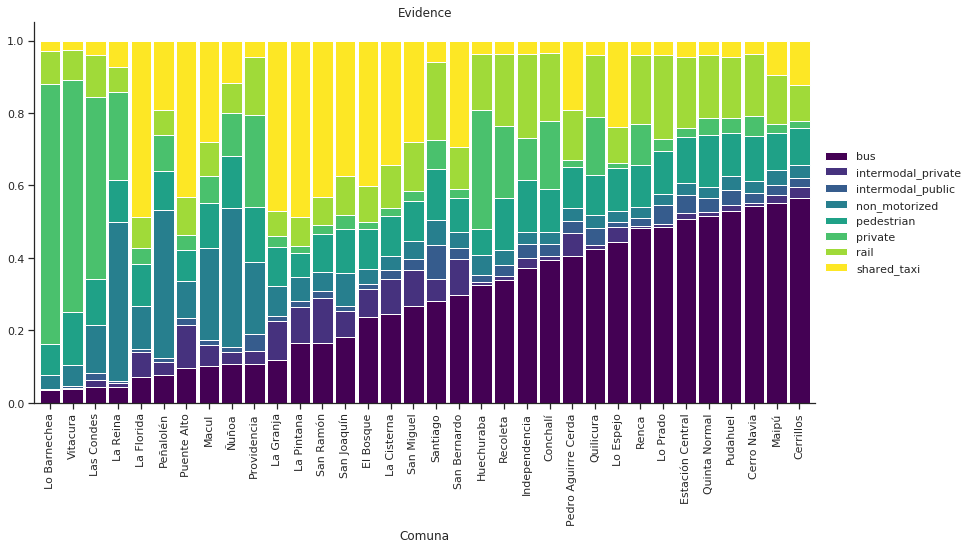

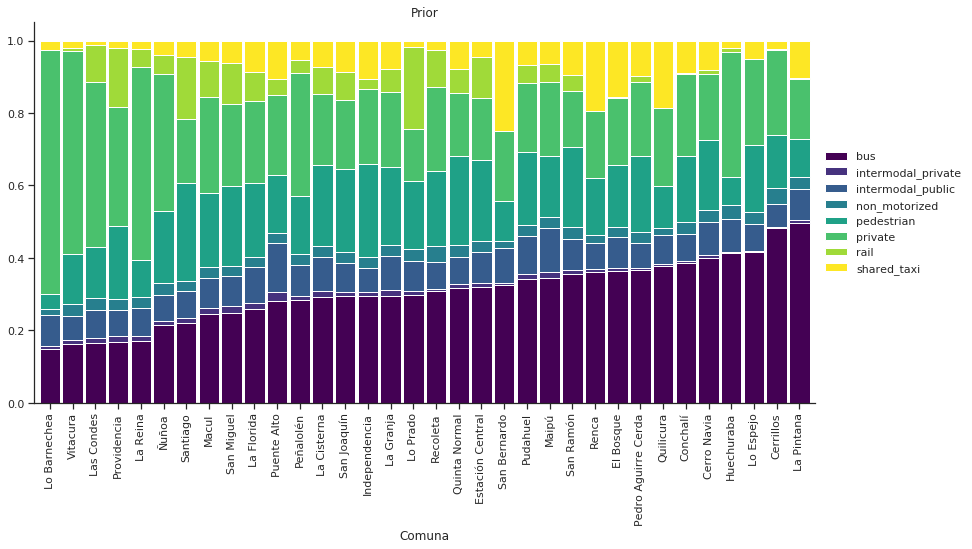

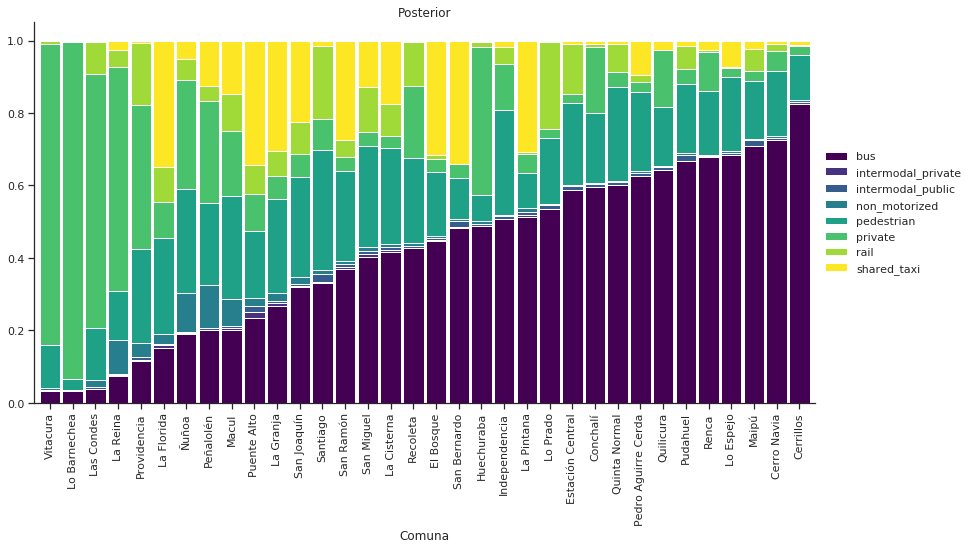

Actual period: night
Epoch 05 reached after 0.155 seconds, error: 1355.697853
Epoch 10 reached after 0.298 seconds, error: 1341.822888
Epoch 15 reached after 0.441 seconds, error: 1338.385486
Epoch 20 reached after 0.584 seconds, error: 1337.349488
Epoch 25 reached after 0.727 seconds, error: 1336.937204
Epoch 30 reached after 0.870 seconds, error: 1336.745442
Epoch 35 reached after 1.014 seconds, error: 1336.647754
Epoch 40 reached after 1.156 seconds, error: 1336.594196
Epoch 45 reached after 1.300 seconds, error: 1336.561250
Epoch 50 reached after 1.444 seconds, error: 1336.538821
Epoch 55 reached after 1.590 seconds, error: 1336.522372
Epoch 60 reached after 1.735 seconds, error: 1336.509830
Epoch 65 reached after 1.882 seconds, error: 1336.499840
Epoch 70 reached after 2.031 seconds, error: 1336.491774
Epoch 75 reached after 2.181 seconds, error: 1336.485094
Epoch 80 reached after 2.330 seconds, error: 1336.479560
Epoch 85 reached after 2.481 seconds, error: 1336.474947
Epoch 90 r

/home/vnavarro/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


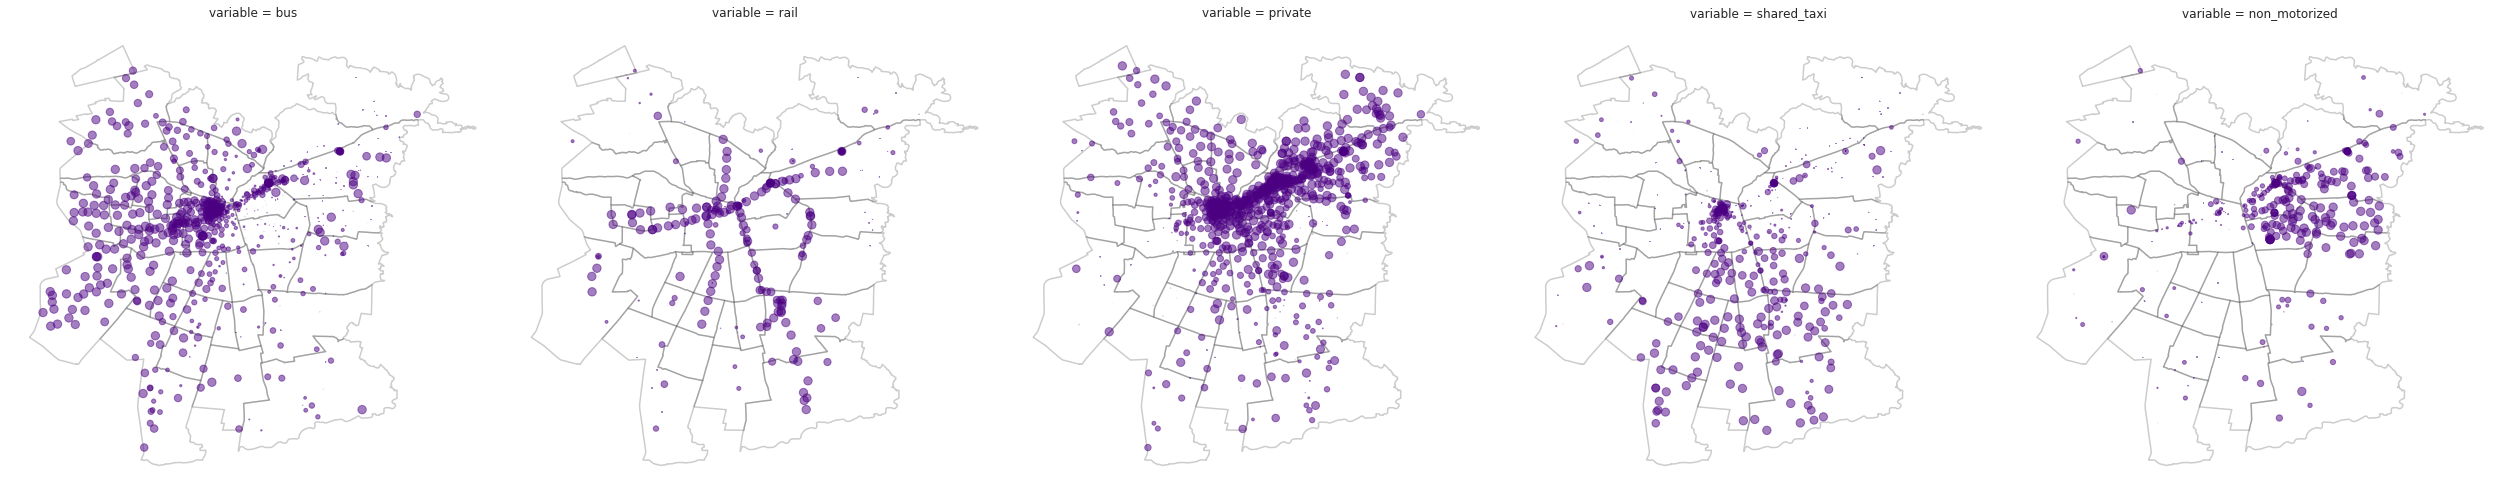

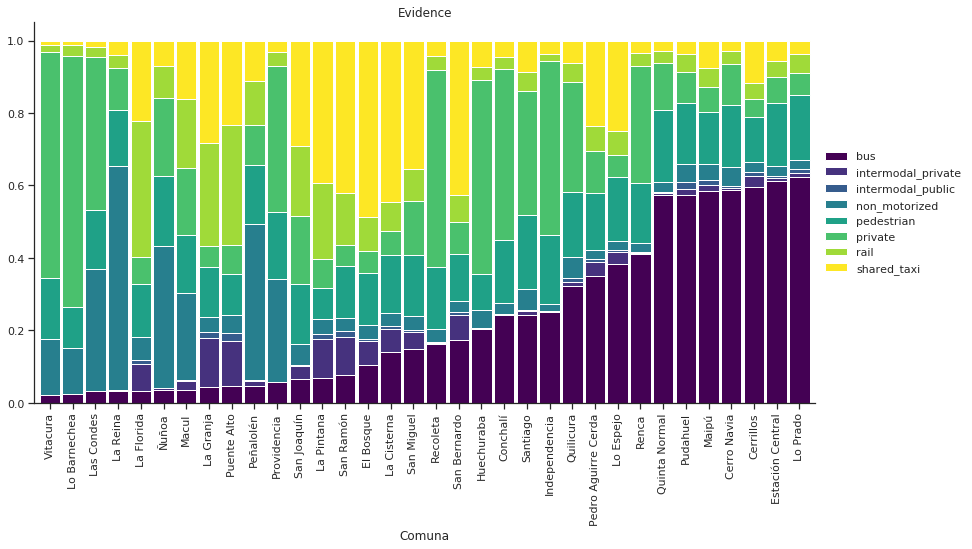

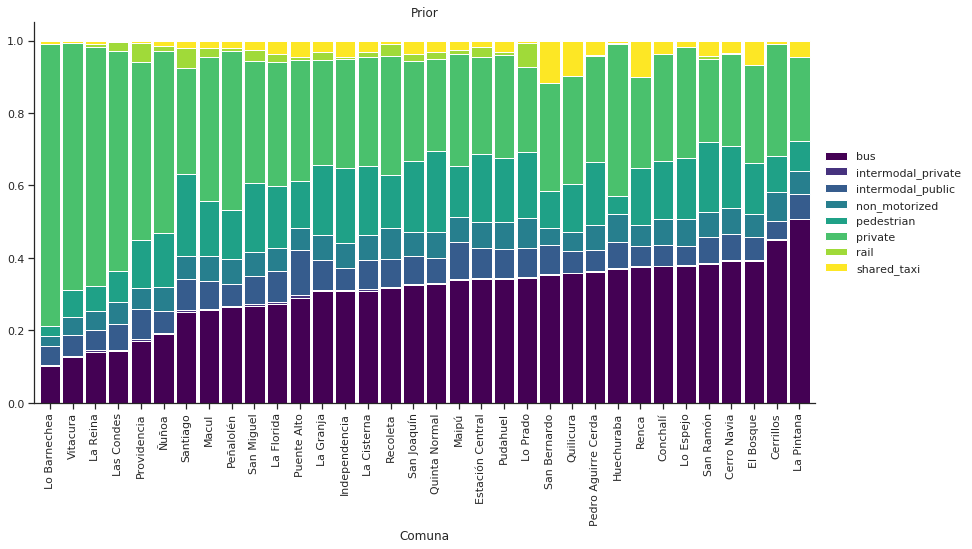

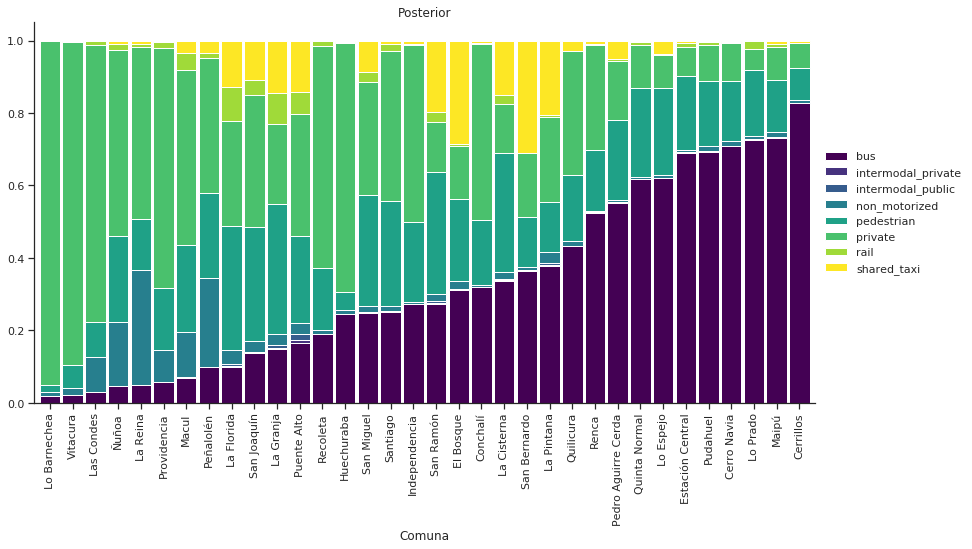

Actual period: night_valley
Epoch 05 reached after 0.168 seconds, error: 1402.847655
Epoch 10 reached after 0.323 seconds, error: 1388.928107
Epoch 15 reached after 0.478 seconds, error: 1387.603645
Epoch 20 reached after 0.632 seconds, error: 1386.753143
Epoch 25 reached after 0.787 seconds, error: 1386.187021
Epoch 30 reached after 0.942 seconds, error: 1385.896414
Epoch 35 reached after 1.097 seconds, error: 1385.715838
Epoch 40 reached after 1.253 seconds, error: 1385.609322
Epoch 45 reached after 1.412 seconds, error: 1385.547233
Epoch 50 reached after 1.574 seconds, error: 1385.508364
Epoch 55 reached after 1.735 seconds, error: 1385.482676
Epoch 60 reached after 1.897 seconds, error: 1385.465601
Epoch 65 reached after 2.061 seconds, error: 1385.453531
Epoch 70 reached after 2.225 seconds, error: 1385.444843
Epoch 75 reached after 2.388 seconds, error: 1385.438212
Epoch 80 reached after 2.554 seconds, error: 1385.432845
Epoch 85 reached after 2.720 seconds, error: 1385.428703
Epo

/home/vnavarro/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


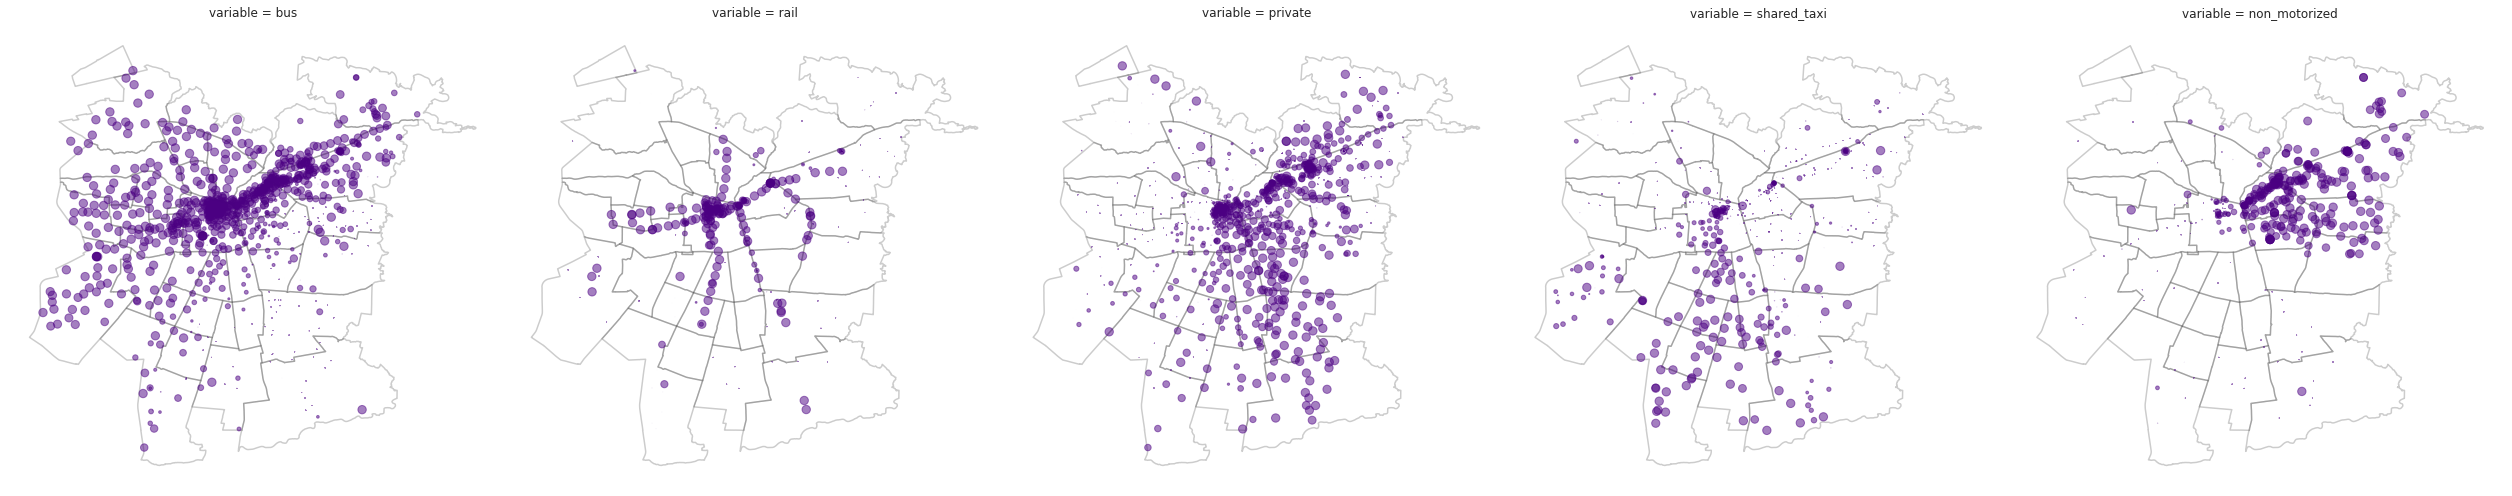

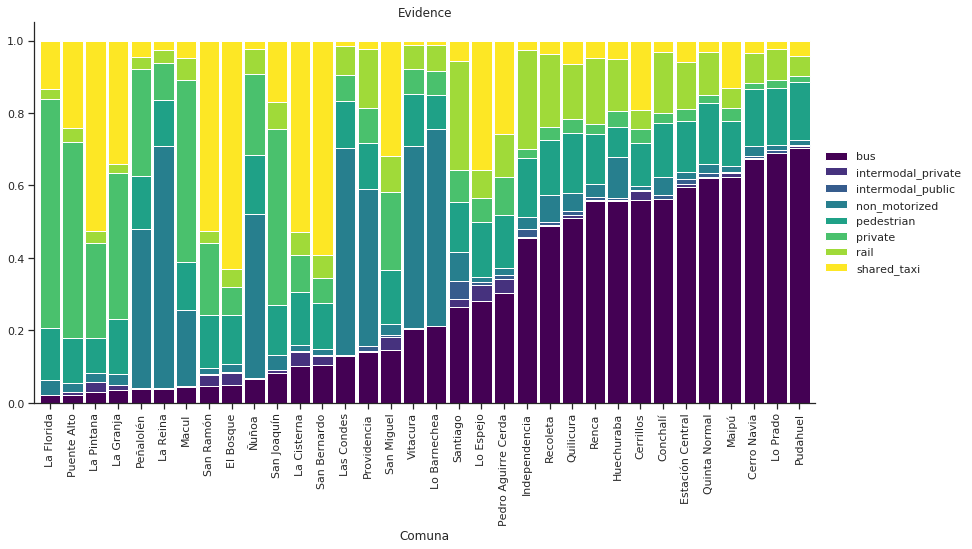

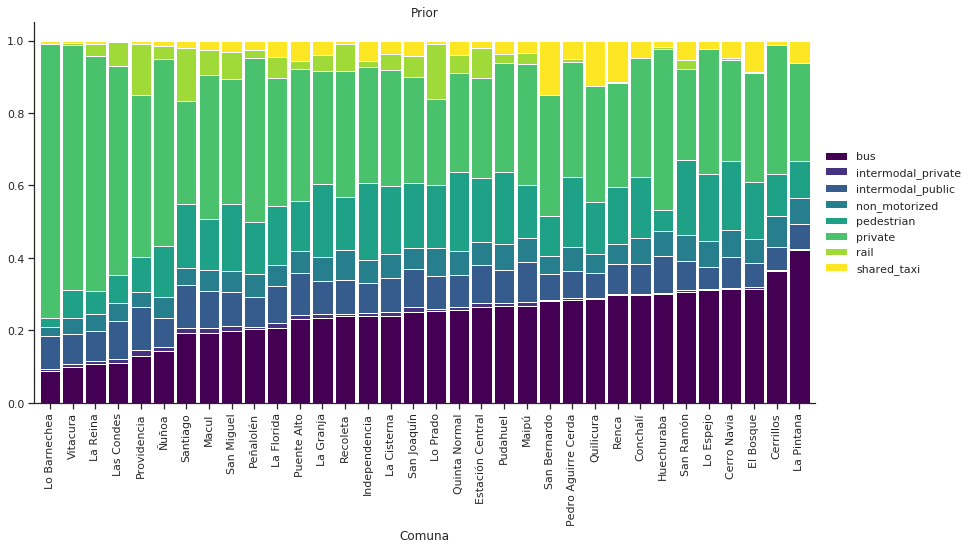

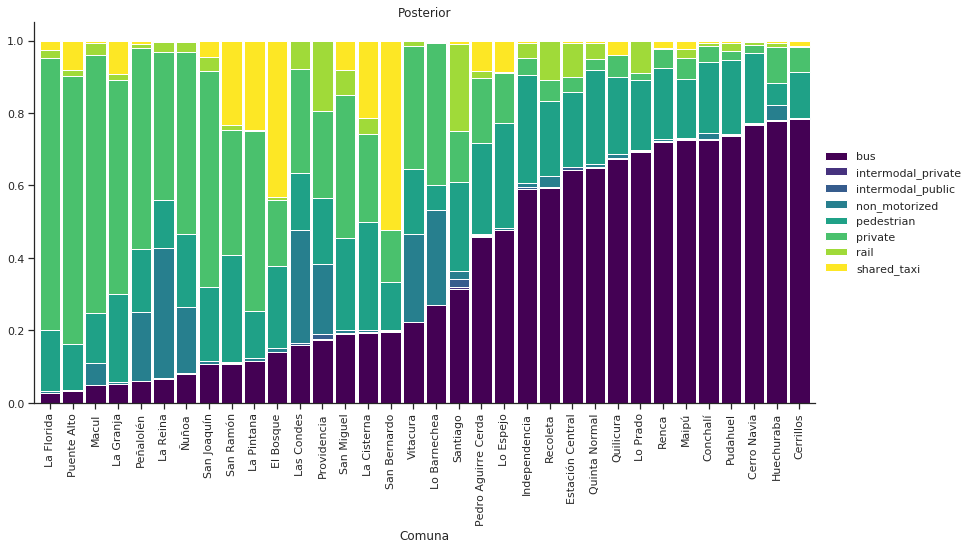

Done...


In [13]:
i=0
for period in periods:
    #if period!='afternoon_peak': break
    print("Actual period:", period)
    # work only on this period
    waypoint_periods = waypoint_index[waypoint_index.period == period]
    # we use a binary matrix this time! we are interested in routes, not in magnitudes
    
    # Should we use TfidfTransformer(norm='l1')?
    to_factorize = csr_matrix(waypoints[waypoint_periods.index].T, copy=True)
    to_factorize[to_factorize > 0] = 1   
    
    # these are the static values used to evaluate the prior from EOD
    zone_features = (waypoint_periods
        .join(zone_income, on='origin_zone', how='inner')
        .rename(columns={'mean_home_income': 'origin_income'})
        .join(zone_income, on='destination_zone', how='inner')
        .rename(columns={'mean_home_income': 'destination_income'})
        .join(zone_distances, on=['origin_zone', 'destination_zone'], how='inner')
        .join(zone_mindist.add_prefix('origen_'), on='origin_zone', how='inner')
        .join(zone_mindist.add_prefix('destino_'), on='destination_zone', how='inner')
        .pipe(lambda x: x[x['origin_zone']!=x['destination_zone']])
                )
    # perform the factorization
    nmf = TSNMF(n_components=len(topic_ids), init='random', verbose=1, tol=1e-06, random_state=6, max_iter=500)
    W = nmf.fit_transform(to_factorize, labels)

    tower_mode = pd.DataFrame(normalize(W, norm='l1') , index=towers.index.tolist(), columns= labeled_keys.keys())
    tower_mode.index.name = 'tower'

    # plot the tower factorization for inspection
    sup_tower_components = (tower_mode
                            .reset_index()
                            .pipe(lambda x: pd.melt(x, id_vars='tower')))

    sup_scaler = MinMaxScaler(feature_range=(sup_min_bubble_size, sup_max_bubble_size))
    sup_scaler.fit(np.sqrt(sup_tower_components.value.values.reshape(-1, 1)))

    sup_geodf = gpd.GeoDataFrame(sup_tower_components.join(towers, on='tower'), crs={'init': 'epsg:4326'})
    g = sns.FacetGrid(data=sup_geodf, col='variable', height=7, aspect=1, sharex=False, sharey=False)
    for ax in g.axes.ravel():
        RM_map.boundary.plot(color='black', alpha=0.2, ax=ax)
    g.map_dataframe(plot_component, 'value', scaler=sup_scaler)

    # retrieve the zone-mode matrix
    flow_mode = (pd.DataFrame(nmf.components_.T , 
                              index=waypoint_periods.index, 
                              columns= labeled_keys.keys())
                 .join(waypoint_periods)
                 .set_index(['origin_zone', 'destination_zone'])
                 .drop(['index', 'period'], axis=1)
    )
    

    # estimate a probability for non motorized trips.
    # we use a logistic function. the 0.5 prob for non motorized trips is assigned at 250 meters.
    pedestrian_p = 1 - 1 / (1 + np.exp(-(zone_distances.loc[flow_mode.index].distance - 0.25)))
    pedestrian_p.name = 'pedestrian'
    
    # CHECK THIS
    intermodal_private_p = (flow_mode['bus'] + flow_mode['rail'] + flow_mode['bus']*flow_mode['rail'])*flow_mode['shared_taxi']*0.5
    intermodal_public_p = (flow_mode['bus']*flow_mode['rail'])*0.5
    flow_evidence = (flow_mode
                      .pipe(normalize_dataframe_rows)
                      .mul(1 - pedestrian_p.values, axis='rows')
                      .assign(pedestrian=pedestrian_p.values)
                      .assign(intermodal_private=intermodal_private_p.values)
                      .assign(intermodal_public=intermodal_public_p.values)
                      .pipe(normalize_dataframe_rows)
    )
    
    #for col in mnlogit_column_names:
    #    if not col in flow_evidence:
    #        flow_evidence[col] = 0
    flow_evidence = flow_evidence.loc[zone_features.set_index(['origin_zone', 'destination_zone']).index]
    flow_evidence = flow_evidence.reindex(mnlogit_column_names, axis=1)
    # plot the evidence modal partition for inspection
    flow_evidence_trips = flow_evidence.mul(period_matrices.loc[period], axis='index')

    (flow_evidence_trips
     .join(zones.Comuna, on='origin_zone')
     .groupby('Comuna')
     .sum()
     .pipe(normalize_dataframe_rows)
     .sort_values('bus')
     .plot(kind='bar', stacked=True, figsize=(14, 7), cmap='viridis', width=0.9, legend=False)
    )
    plt.title('Evidence')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    sns.despine()

    # estimate the prior information using the EOD mnlogit model
    zone_priors = mnlogit.predict(zone_features.set_index(['origin_zone', 'destination_zone']))
    zone_priors.columns = mnlogit_column_names
    flow_priors = zone_priors.loc[flow_evidence.index]

    # plot the prior partition for inspection
    flow_prior_trips = flow_priors.mul(period_matrices.loc[period], axis='index')

    (flow_prior_trips
     .join(zones.Comuna, on='origin_zone')
     .groupby('Comuna')
     .sum()
     .pipe(normalize_dataframe_rows)
     .sort_values('bus')
     .plot(kind='bar', stacked=True, figsize=(14, 7), cmap='viridis', width=0.9, legend=False)
    )
    plt.title('Prior')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    sns.despine()

    # use bayes theorem to estimate the posterior modal partition
    denominator = flow_priors.mul(flow_evidence).sum(axis=1)
    flow_posteriors = flow_evidence.mul(flow_priors).div(denominator, axis='index')

    # plot the posterior partition for inspection
    flow_trips = flow_posteriors.mul(period_matrices.loc[period], axis='index')

    (flow_trips
     .join(zones.Comuna, on='origin_zone')
     .groupby('Comuna')
     .sum()
     .pipe(normalize_dataframe_rows)
     .sort_values('bus')
     .plot(kind='bar', stacked=True, figsize=(14, 7), cmap='viridis', width=0.9, legend=False)
    )
    plt.title('Posterior')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    sns.despine()

    # export data
    raw_tower_mode = pd.DataFrame(W , index=towers.index.tolist(), columns= labeled_keys.keys())
    raw_tower_mode.index.name = 'tower'
    raw_tower_mode.to_csv('2020_results/flow_model_{}_tower_mode.csv.gz'.format(period))

    flow_mode.to_csv('2020_results/flow_model_{}_zone_mode.csv.gz'.format(period))

    (flow_posteriors
     .reset_index()
     .assign(period=period)
     .to_json('2020_results/modal_partition_zones_{}.json.gz'.format(period), 
              compression='gzip', orient='records', lines=True)
    )
    # done!
    plt.show()
    i+=1
print("Done...")